In [169]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [216]:
def getDocuments(html_txt, ID):
    singleFundDocuments = pd.DataFrame(columns=[['ID','documentName', 'link']])
    curr_txt = html_txt
    name = 'cool name'

    while name != '':
        curr_txt = curr_txt[curr_txt.find("https://dokumenty.analizy.pl/pobierz"):]
        link_end = curr_txt.find(">\n")-1
        link = curr_txt[:link_end]
        name_from = curr_txt.find('''<span class="bold">''')
        curr_txt = curr_txt[name_from+19:]
        name_till = curr_txt.find(" </span>")
        name = curr_txt[:name_till]
        if name != '':
            # print(name, "|", link)
            singleFundDocuments = pd.concat([pd.DataFrame(data={'ID':[ID],'documentName':[name], 'link':[link]}), singleFundDocuments])
    return singleFundDocuments[['ID', 'documentName', 'link']]
    

def ScrapeSingleHTML(url):
    headers = {'Accept-Encoding': 'identity'}
    r = requests.get(url, headers=headers)
    return r.text

def retrieveHistoricaldata(code):
    try:
        url = 'https://www.analizy.pl/api/quotation/fio/'+code
        r = requests.get(url)
        df = pd.DataFrame(r.json()['series'][0]['price'])
    except:
        df = 0
    return df

def retrieveVolatilityFromHistoricaldata(code):
    try:
        url = 'https://www.analizy.pl/api/quotation/fio/'+code
        r = requests.get(url)
        df = np.var(pd.DataFrame(r.json()['series'][0]['price'])['value'])
    except:
        df = 0
    return df

In [217]:
# scrapping data from Puls Biznesu ~900 funds
f = open('pb.txt','r',encoding='utf8')
pd_txt = f.read()
f.close()

subFunds = pd.DataFrame(columns=[['symbol',  'link_part', 'masterFund', 'subFund', 'link', 'volatility']])
curr_txt = pd_txt
symbol = 'VERYCOOLSYMBOL'

while symbol != '':
    html_from = curr_txt.find('/instrument/') + len('/instrument/')
    curr_txt = curr_txt[html_from:]
    symbol_till = curr_txt.find('/')
    symbol = curr_txt[:symbol_till]
    curr_txt = curr_txt[len(symbol)-1:]

    curr_txt_till = curr_txt.find('"')
    link_part = curr_txt[2:curr_txt_till]
    curr_txt = curr_txt[curr_txt_till:]
    curr_txt_till = curr_txt.find('</a>')
    subFund_and_masterFund = curr_txt[2:curr_txt_till]

    secondBracetLocation = subFund_and_masterFund[::-1][1:].find('(')
    masterFund = subFund_and_masterFund[len(subFund_and_masterFund)-secondBracetLocation-1:len(subFund_and_masterFund)-1]
    subFund = subFund_and_masterFund[:len(subFund_and_masterFund)-secondBracetLocation-3]

    curr_txt = curr_txt[len(subFund_and_masterFund):]
    link = "https://www.analizy.pl/fundusze-inwestycyjne-otwarte/"+symbol+'/'+link_part+"#moreInfo"

    volatility = retrieveVolatilityFromHistoricaldata(symbol)

    # print(symbol, "|", link_part,"|", masterFund,"|", subFund, '|', link)
    # print(link)
    subFunds = pd.concat([pd.DataFrame(data={'symbol':[symbol],  'link_part':[link_part], 'masterFund':[masterFund], 'subFund':[subFund], 'link':[link], 'volatility':[volatility]}), subFunds])

subFunds = subFunds[[  'symbol',     'link_part',    'masterFund',  'subFund', 'link', 'volatility']]

In [210]:
allDocuments = pd.DataFrame(columns=[['ID','documentName', 'link']])
links = subFunds['link']


for i in range(len(links)):
    try:
        allDocuments = pd.concat([getDocuments(ScrapeSingleHTML(subFunds['link'][i]), subFunds['symbol'][i]), allDocuments])
    except:
        pass

allDocuments = allDocuments[['ID', 'documentName', 'link']]

In [212]:
allDocuments.to_csv('allDocumentsVerFinal.csv')

In [185]:
baseData = pd.read_excel('Lista TFIFISFI.xlsx').drop(columns='Lp.')

In [200]:
baseData[baseData['Aktywny (FI)'] == 'Tak']

,Identyfikator krajowy TFI,TFI,Aktywny (TFI),Identyfikator krajowy FI,Fundusz,Numer w RFI,Aktywny (FI),Identyfikator krajowy SFI,Subfundusz
0,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00314,Subfundusz Generali Obligacje: Globalne Rynki ...
1,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIH00085,Subfundusz UniTotal Trend w likwidacji
2,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00082,Subfundusz Generali Profit Plus
3,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00093,Subfundusz Generali Obligacje Aktywny
4,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00125,Subfundusz SGB Bankowy
...,...,...,...,...,...,...,...,...,...
2828,PLTFIH00003,INVENTUM TFI S.A.,Nie,PLFIOH00168,INVENTUM Parasol FIO w likwidacji,457.0,Tak,PLSFIH00164,INVENTUM Stabilnego Wzrostu Subfundusz w likwi...
2829,PLTFIH00003,INVENTUM TFI S.A.,Nie,PLFIOH00168,INVENTUM Parasol FIO w likwidacji,457.0,Tak,PLSFIH00163,Idea Ochrony Kapitału Subfundusz w likwidacji
2830,PLTFIH00003,INVENTUM TFI S.A.,Nie,PLFIOH00168,INVENTUM Parasol FIO w likwidacji,457.0,Tak,PLSFIH00162,INVENTUM Obligacji Subfundusz w likwidacji
2834,PLTFIH00003,INVENTUM TFI S.A.,Nie,PLFIZH00139,IDEA 3 FIZ AN w likwidacji,475.0,Tak,NaN,NaN


In [180]:
subFunds.iloc[32:]

,symbol,link_part,masterFund,subFund,link
32,VIG03B,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji Korporacyjnych A,https://www.analizy.pl/fundusze-inwestycyjne-o...
33,VIG03,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji Korporacyjnych,https://www.analizy.pl/fundusze-inwestycyjne-o...
34,VIG02B,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji A,https://www.analizy.pl/fundusze-inwestycyjne-o...
35,VIG02,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji,https://www.analizy.pl/fundusze-inwestycyjne-o...
36,VIG01B,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Konserwatywny A,https://www.analizy.pl/fundusze-inwestycyjne-o...
...,...,...,...,...,...
958,AGF71_E,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Małych i Średnich Spółek (EUR),https://www.analizy.pl/fundusze-inwestycyjne-o...
959,AGF71,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Małych i Średnich Spółek,https://www.analizy.pl/fundusze-inwestycyjne-o...
960,AGF93_U,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Globalnych (USD),https://www.analizy.pl/fundusze-inwestycyjne-o...
961,AGF93_E,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Globalnych (EUR),https://www.analizy.pl/fundusze-inwestycyjne-o...


In [196]:
subFunds.iloc[32:]['subFund'].unique()

array(['VIG / C-QUADRAT Obligacji Korporacyjnych A',
       'VIG / C-QUADRAT Obligacji Korporacyjnych',
       'VIG / C-QUADRAT Obligacji A', 'VIG / C-QUADRAT Obligacji',
       'VIG / C-QUADRAT Konserwatywny A', 'VIG / C-QUADRAT Konserwatywny',
       'VIG / C-QUADRAT GreenStars A', 'VIG / C-QUADRAT GreenStars',
       'VIG / C-QUADRAT Global Growth Trends A',
       'VIG / C-QUADRAT Global Growth Trends', 'VIG / C-QUADRAT Akcji A',
       'VIG / C-QUADRAT Akcji', 'UNIQA Stabilnego Wzrostu A1',
       'UNIQA Stabilnego Wzrostu', 'UNIQA Selektywny Akcji Polskich A1',
       'UNIQA Selektywny Akcji Polskich', 'UNIQA Selective Equity A1',
       'UNIQA Selective Equity', 'UNIQA Ostrożnego Inwestowania A1',
       'UNIQA Ostrożnego Inwestowania',
       'UNIQA Obligacji Korporacyjnych A1',
       'UNIQA Obligacji Korporacyjnych', 'UNIQA Obligacji A1',
       'UNIQA Obligacji', 'UNIQA Makroalokacji A1', 'UNIQA Makroalokacji',
       'UNIQA Globalnych Strategii Dłużnych A1',
       'UNIQA G

In [195]:
len(pd.merge(baseData, subFunds.iloc[32:], left_on=['Subfundusz'], right_on=['subFund'], how='left')['symbol'].unique())

130

In [207]:
pd.merge(baseData, subFunds.iloc[32:], left_on=['Fundusz'], right_on=['masterFund'], how='right').drop_duplicates('subFund')

,Identyfikator krajowy TFI,TFI,Aktywny (TFI),Identyfikator krajowy FI,Fundusz,Numer w RFI,Aktywny (FI),Identyfikator krajowy SFI,Subfundusz,symbol,link_part,masterFund,subFund,link
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIG03B,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji Korporacyjnych A,https://www.analizy.pl/fundusze-inwestycyjne-o...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIG03,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji Korporacyjnych,https://www.analizy.pl/fundusze-inwestycyjne-o...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIG02B,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji A,https://www.analizy.pl/fundusze-inwestycyjne-o...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIG02,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Obligacji,https://www.analizy.pl/fundusze-inwestycyjne-o...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIG01B,vig-c-quadrat-fundusz-inwestycyjny-otwarty-sub...,VIG / C-QUADRAT FIO,VIG / C-QUADRAT Konserwatywny A,https://www.analizy.pl/fundusze-inwestycyjne-o...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9549,PLTFI000036,AgioFunds TFI S.A.,Tak,PLSFIO00216,AGIO SFIO,483.0,Tak,PLSFIO00063,Subfundusz Agio Akcji Małych i Średnich Spółek,AGF71_E,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Małych i Średnich Spółek (EUR),https://www.analizy.pl/fundusze-inwestycyjne-o...
9553,PLTFI000036,AgioFunds TFI S.A.,Tak,PLSFIO00216,AGIO SFIO,483.0,Tak,PLSFIO00063,Subfundusz Agio Akcji Małych i Średnich Spółek,AGF71,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Małych i Średnich Spółek,https://www.analizy.pl/fundusze-inwestycyjne-o...
9557,PLTFI000036,AgioFunds TFI S.A.,Tak,PLSFIO00216,AGIO SFIO,483.0,Tak,PLSFIO00063,Subfundusz Agio Akcji Małych i Średnich Spółek,AGF93_U,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Globalnych (USD),https://www.analizy.pl/fundusze-inwestycyjne-o...
9561,PLTFI000036,AgioFunds TFI S.A.,Tak,PLSFIO00216,AGIO SFIO,483.0,Tak,PLSFIO00063,Subfundusz Agio Akcji Małych i Średnich Spółek,AGF93_E,agio-specjalistyczny-fundusz-inwestycyjny-otwa...,AGIO SFIO,AGIO Akcji Globalnych (EUR),https://www.analizy.pl/fundusze-inwestycyjne-o...


In [206]:
pd.merge(baseData, subFunds.iloc[32:], left_on=['Fundusz'], right_on=['masterFund'], how='right').drop_duplicates('subFund')['Identyfikator krajowy FI'].unique()

array([nan, 'PLFIO000287', 'PLSFIO00294', 'PLSFIO00342', 'PLSFIO00263',
       'PLSFIO00262', 'PLFIO000318', 'PLSFIO00258', 'PLSFIO00267',
       'PLFIO000285', 'PLSFIO00219', 'PLSFIO00388', 'PLFIO000290',
       'PLFIO000317', 'PLSFIO00361', 'PLSFIO00252', 'PLSFIO00251',
       'PLSFIO00397', 'PLFIO000314', 'PLFIO000312', 'PLSFIO00248',
       'PLSFIO00249', 'PLSFIO00444', 'PLFIO000311', 'PLFIO000310',
       'PLSFIO00247', 'PLFIO000308', 'PLSFIO00245', 'PLFIO000307',
       'PLSFIO00241', 'PLSFIO00435', 'PLSFIO00242', 'PLSFIO00238',
       'PLFIO000304', 'PLSFIO00240', 'PLFIO000305', 'PLSFIO00332',
       'PLSFIO00278', 'PLFIO000292', 'PLSFIO00426', 'PLSFIO00325',
       'PLSFIO00230', 'PLFIO000321', 'PLSFIO00379', 'PLFIO000302',
       'PLSFIO00237', 'PLSFIO00370', 'PLSFIO00301', 'PLFIO000296',
       'PLFIO000294', 'PLFIO000293', 'PLSFIO00225', 'PLSFIO00472',
       'PLFIO000289', 'PLFIO000288', 'PLSFIO00463', 'PLSFIO00496',
       'PLSFIO00489', 'PLFIO000284', 'PLFIO000283', 'PLFI

In [197]:
pd.merge(baseData, subFunds.iloc[32:], left_on=['Fundusz','Subfundusz'], right_on=['masterFund','subFund'], how='left')

,Identyfikator krajowy TFI,TFI,Aktywny (TFI),Identyfikator krajowy FI,Fundusz,Numer w RFI,Aktywny (FI),Identyfikator krajowy SFI,Subfundusz,symbol,link_part,masterFund,subFund,link
0,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00314,Subfundusz Generali Obligacje: Globalne Rynki ...,NaN,NaN,NaN,NaN,NaN
1,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIH00085,Subfundusz UniTotal Trend w likwidacji,NaN,NaN,NaN,NaN,NaN
2,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00082,Subfundusz Generali Profit Plus,NaN,NaN,NaN,NaN,NaN
3,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00093,Subfundusz Generali Obligacje Aktywny,NaN,NaN,NaN,NaN,NaN
4,PLTFI000001,Generali Investments TFI S.A.,Tak,PLSFIO00267,Generali Fundusze SFIO,484.0,Tak,PLSFIO00125,Subfundusz SGB Bankowy,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,PLTFIH00005,TFI SKOK S.A.,Nie,PLFIOH00036,SKOK FIO Fundusz Funduszy,289.0,Nie,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2853,PLTFIH00005,TFI SKOK S.A.,Nie,PLFIOH00040,SKOK FIO Akcji,307.0,Nie,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2854,PLTFIH00005,TFI SKOK S.A.,Nie,PLFIZH00211,SKOK FIZ 1 w likwidacji,598.0,Nie,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2855,PLTFIH00005,TFI SKOK S.A.,Nie,PLFIOH00005,SKOK FIO Stabilny Zmiennej Alokacji,191.0,Nie,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
subFunds.reset_index(inplace=True)
subFunds.drop(columns=['index'], inplace=True)

In [121]:
subFunds['link']

0      https://www.analizy.pl/fundusze-inwestycyjne-o...
1      https://www.analizy.pl/fundusze-inwestycyjne-o...
2      https://www.analizy.pl/fundusze-inwestycyjne-o...
3      https://www.analizy.pl/fundusze-inwestycyjne-o...
4      https://www.analizy.pl/fundusze-inwestycyjne-o...
                             ...                        
958    https://www.analizy.pl/fundusze-inwestycyjne-o...
959    https://www.analizy.pl/fundusze-inwestycyjne-o...
960    https://www.analizy.pl/fundusze-inwestycyjne-o...
961    https://www.analizy.pl/fundusze-inwestycyjne-o...
962    https://www.analizy.pl/fundusze-inwestycyjne-o...
Name: link, Length: 963, dtype: object

In [149]:
allDocuments.to_csv('allDocumentsVer1.csv')

In [151]:
allDocuments['documentName'].unique()

array(['Skład portfela', 'KIID', 'Prospekt informacyjny',
       'Karta funduszu', 'Tabela opłat', 'Sprawozdanie', 'Oferta', 'KID'],
      dtype=object)

In [152]:
allDocuments[allDocuments['documentName']=='Skład portfela']

,ID,documentName,link
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/AGF93/...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/AGF93_...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/AGF93_...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/AGF71/...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/AGF71_...
...,...,...,...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/VIG01B...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/VIG02/...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/VIG02B...
0,todo,Skład portfela,https://dokumenty.analizy.pl/pobierz/fi/VIG03/...


# DEV

In [173]:
def retrieveHistoricaldata(code):
    url = 'https://www.analizy.pl/api/quotation/fio/'+code
    r = requests.get(url)
    return pd.DataFrame(r.json()['series'][0]['price'])


In [153]:
url = 'https://www.analizy.pl/api/quotation/fio/AGF93'

r = requests.get(url)

In [208]:
r.json()

{'id': 'AGF93',
 'label': 'AGIO Akcji Globalnych',
 'currency': 'PLN',
 'isRegular': False,
 'isDividend': False,
 'periods': [{'period': '1M',
   'label': '1M',
   'start': '2022-09-21',
   'end': '2022-10-21'},
  {'period': '3M', 'label': '3M', 'start': '2022-07-21', 'end': '2022-10-21'},
  {'period': '12M',
   'label': '12M',
   'start': '2021-10-21',
   'end': '2022-10-21'},
  {'period': '36M',
   'label': '36M',
   'start': '2019-10-21',
   'end': '2022-10-21'},
  {'period': '60M',
   'label': '60M',
   'start': '2017-10-20',
   'end': '2022-10-21'},
  {'period': '120M',
   'label': '120M',
   'start': '2012-10-19',
   'end': '2022-10-21'},
  {'period': 'YTD',
   'label': 'YTD',
   'start': '2021-12-31',
   'end': '2022-10-21'},
  {'period': 'MAX',
   'label': 'MAX',
   'start': '2012-12-04',
   'end': '2022-10-21'}],
 'events': [{'date': '2022-07-01', 'label': 'akcji polskich uniwersalne'}],
 'dividends': [],
 'series': [{'id': 'fund_AGF93',
   'label': 'Fundusz',
   'currency': 

In [172]:
pd.DataFrame(r.json()['series'][0]['price'])

,date,value
0,2012-12-04,966.51
1,2012-12-05,995.36
2,2012-12-06,995.36
3,2012-12-07,995.36
4,2012-12-10,995.36
...,...,...
2488,2022-10-17,1407.52
2489,2022-10-18,1407.52
2490,2022-10-19,1421.78
2491,2022-10-20,1421.78


In [168]:
np.var(pd.DataFrame(r.json()['series'][0]['price'])['value'])

55022.579029401895

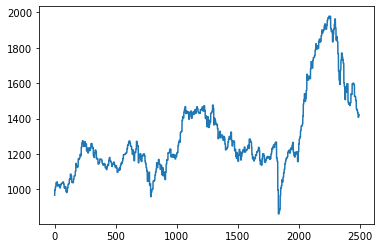

In [170]:
plt.plot(pd.DataFrame(r.json()['series'][0]['price'])['value'])

In [46]:
headers = {'Accept-Encoding': 'identity'}
url = "https://www.analizy.pl/fundusze-inwestycyjne-otwarte/AGF93/agio-specjalistyczny-fundusz-inwestycyjny-otwarty-subfundusz-agio-akcji-globalnych#moreInfo"

r = requests.get(url, headers=headers)
txt = r.text

In [55]:
txt = r.text

txt.find("https://dokumenty.analizy.pl/pobierz")

276720

In [66]:
len('<span class="bold">')

19

In [76]:
curr_txt = txt
name = 'cool name'

while name != '':
    curr_txt = curr_txt[curr_txt.find("https://dokumenty.analizy.pl/pobierz"):]
    link_end = curr_txt.find(">\n")-1
    link = curr_txt[:link_end]
    name_from = curr_txt.find('''<span class="bold">''')
    curr_txt = curr_txt[name_from+19:]
    name_till = curr_txt.find(" </span>")
    name = curr_txt[:name_till]
    if name != '':
        print(name, "|", link)

Tabela opłat | https://dokumenty.analizy.pl/pobierz/fi/AGF93/TOU/2022-09-01
Karta funduszu | https://dokumenty.analizy.pl/pobierz/fi/AGF93/KA/2022-09-30
Prospekt informacyjny | https://dokumenty.analizy.pl/pobierz/fi/AGF93/PE/2022-09-01
KIID | https://dokumenty.analizy.pl/pobierz/fi/AGF93/KL/2022-07-01
Skład portfela | https://dokumenty.analizy.pl/pobierz/fi/AGF93/SP/2022-09-30


In [74]:
# curr_txt = txt
curr_txt = curr_txt[curr_txt.find("https://dokumenty.analizy.pl/pobierz"):]
link_end = curr_txt.find(">\n")-1
link = curr_txt[:link_end]
name_from = curr_txt.find('''<span class="bold">''')
curr_txt = curr_txt[name_from+19:]
name_till = curr_txt.find(" </span>")
name = curr_txt[:name_till]
name

''

In [57]:
txt[276720:].find(">\n")

61

In [59]:
txt[276720:276720+60]

'https://dokumenty.analizy.pl/pobierz/fi/AGF93/TOU/2022-09-01'

In [ ]:
.find(<span class="bold">)